# Forecasting - using Cycle Times

Let's first define what _Cycle Time_ means or how it's defined for the purpose of this notebook:

__Cycle Time__:
  > "...the time between two items emerging from a process"

This notebook illustrates an analysis and forecasting for data based on _Cycle Time_ as defined above.
In particular the following aspects are considered:

* working days versus calendar days
* working hours versus 24h
* batches of deliveries or single items
* consistency with the 'Delivery Rate'
* noise in the data due to sloppy/faulty entry dates of the data

## Table of contents

* [Set-up](#Set-up)
* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Data analysis](#Data-analysis)
* [Empirical CDF](#Empirical-CDF)
* [Simple forecast using the empirical data](#Simple-forecast-using-the-empirical-data)
* [Forecasting using an Erlang distribution](#Forecasting-using-an-Erlang-distribution)
* [Finding an appropriate subsequence](#Finding-an-appropriate-subsequence)
* [References](#References)

## Set-up

In [1]:
require Chi2fit.Distribution
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math
:"do not show this result in output"

## Data and simulation set-up

The data set (`team.csv`) consists of several hundreds of completed items in the span of 1 year. In this case the data is exported from [Jira](http://jira.atlassian.com). Here, we take as a completion date the resolution times.

In [12]:
#
# Completed items have a resolution date which is in the column "Resolved"
# Jira exports time data as shown above.
#
deliveries = "/app/notebooks/data/team.csv"
|> File.stream!
|> U.csv_to_list("Resolved", header?: true, format: "{0D}/{Mshort}/{YY} {h24}:{0m}")

IO.inspect(deliveries, print: false, limit: 3)
IO.puts "Number of completed items: #{length(deliveries)}"
:"do not show this result in output"

[~N[2019-05-13 13:03:00], ~N[2019-05-13 11:42:00], ~N[2019-05-13 09:24:00], ...]
Number of completed items: 879


First, we set some parameters that will be used later on in this notebook. Especially important for analyzing the data, is that we need to make a choice for how to handle:

* working days vs calendar days,
* working hours vs 24h,
* look at batches of deliveries or at single deliveries,
* decide on the size of a cluster of data for fitting to a known distribution.

In [3]:
##
## Data analysis
##

# Working hours: 8AM to 8PM
workhours = {8,20}

# Correct for working days and/or working hours (:weekday, :worktime, :"weekday+worktime")
correct = :"weekday+worktime"

# Cutoff for minimum amount of time between consecutive deliveries (15/12/60 corresponds to 15 minutes)
cutoff = 15/(12*60)

# Size of the bins to group the data (2/24 means a granularity of 2 hours)
binsize = 2/12

# The noise to add to the delivery times to estimagte the error due to sloppy/faulty administration
#noise = D.normal(0.0, 2.0/12)
noise = fn -> 0.0 end # No noise

##
## Forecasting
##

# The size of the backlog, e.g. 100 backlog items
size = 1000

##
## Monte Carlo simulations stuff
##

# Number of iterations to use in the Monte Carlo
iterations = 100

# Number of probes to use in the chi2 fit
probes = 50_000

##
## Fitting a distribution
##

# The range of the parameter to look for a (global) minimum
initial = [{0.1,50},{0.1,50}]
:"do not show this result in output"

In [4]:
{startofday,endofday} = workhours
hours_in_day = endofday - startofday
:"do not show this result in output"

In [5]:
# Cycle Times in number of calendar days
ctlist = deliveries
|> Stream.chunk_every(2, 1, :discard)
|> Stream.map(fn [d1,d2] -> NaiveDateTime.diff(d1,d2) end) # Calculate the time difference between two consecutive deliveries in seconds
|> Enum.map(& &1/24/3600) # Convert the number of seconds to number of days
IO.inspect(ctlist, print: false, limit: 3)
:"do not show this result in output"

[0.05625, 0.09583333333333334, 0.002777777777777778, ...]


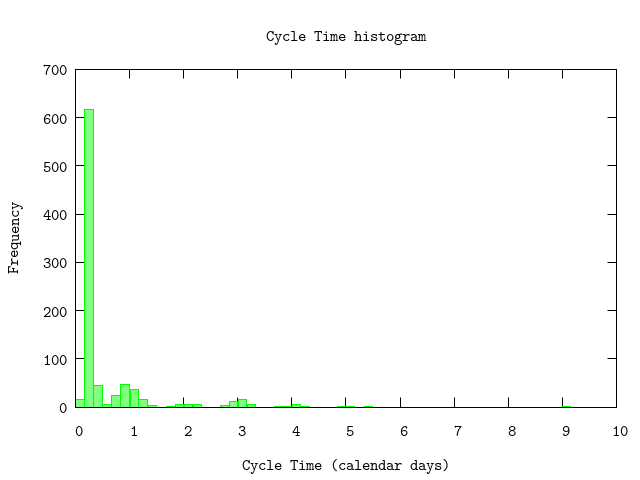

In [6]:
P.histogram(ctlist,
    bin: binsize,
    plottitle: "Cycle Time histogram",
    xlabel: "Cycle Time (calendar days)",
    ylabel: "Frequency",
    xrange: '[0:]')
:"this is an inline image"

The histogram shows some 'strange' humps. It could be due to so-called multi-modal data. Muti-modal means that the data has a 'preference' for certain values (= the humps) and usually corresponds to different types of work. However, it is more likely to becaused by patterns in the data which we may be able to correct for.

## Data analysis

On first site there appear to be bumps around _Cycle Times_ of a whole number of days. Second, between 0 and 1 the _Cycle Time_ exhibits a dip. There are two main factors that may be relevant and may explain this observed behaviour:

1. __Work hours__. Most people have regularised working hours somewhere between 8AM and 18PM depending on how early they start work,
1. __Weekdays__. People don't work during the weekends,
1. __Sloppy administration__. What often happens is that work has completed at some time of the day and instead of immediately registering the work as done, this often happens a couple of hours later, or the next day, or even at the end of an iteration (just before reporting).

First we will examine the first 2 factors. One way of handling the 3rd factor is to add a random noise to the completion dates and estimate the effect of this.

For now, we'll assume no noise.

In [7]:
# No noise
noise = fn -> 0.0 end

# Assume that in practice deliveries never are at exactly the same time. If so, then we'll further assume that
# this is due to 'sloppy' administration. When this happens we set the _Cycle Time_ to a certain minimum space
# between them (the cutoff)
fun = fn dat -> dat
  # Map the delivery times to numbers: the number of days since the epoch Jan 1st, 1970:
  |> Stream.map(& NaiveDateTime.diff(&1, ~N[1970-01-01 00:00:00], :second)/(24*3600))

  # Adjust the time for working hours: 8AM - 22PM
  # This maps the period of working hours to the interval 0..1
  |> U.adjust_times(correct: correct, workhours: workhours)

  # Apply noise to our data
  |> Stream.map(& &1+noise.())
  
  # Sort again to get properly ordered completeion dates
  |> Enum.sort(& &1>&2)
  
  # Calculate time differences with cut-off
  |> U.time_diff(cutoff: cutoff)
end
:"do not show this result in output"

Next, recalculate the _Cycle Times_ with the corrections specified above. This basically switches from _calendar days_ to _working days_.

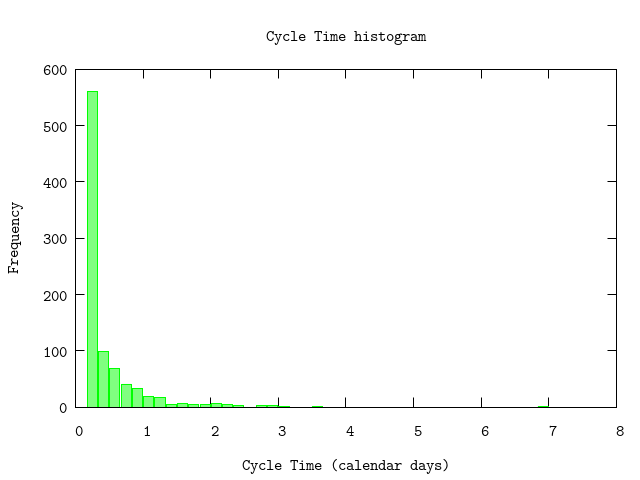

In [8]:
# Cycle Times in number of days
ctlist = deliveries
|> fun.()

ctlist |> P.histogram(
    bin: binsize,
    plottitle: "Cycle Time histogram",
    xlabel: "Cycle Time (calendar days)",
    ylabel: "Frequency",
    xrange: '[0:]')
:"this is an inline image"

The effect of the corrections is clearly visible in the chart:

* much more smoothened graph without significant bumps,
* no small bar to the left of the largest bar; this is caused by the cutoff.

We did not take into account public holidays so this could still introduce small bumps but we expect that this effect is 'within' the noise of the data.

## Empirical CDF

In [9]:
hdata = ctlist |> U.to_bins({binsize,0})
IO.puts "#{length(ctlist)} Cycle Times reduced to #{length(hdata)} bins"
:"do not show this result in output"

878 Cycle Times reduced to 19 bins


The data returned contains a list of tuples each describing a bin:
* the end-point of the bin,
* the proportional number of events for this bin (the total count is normalized to one),
* the lower value of the error bound,
* the upper value of the error bound.

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

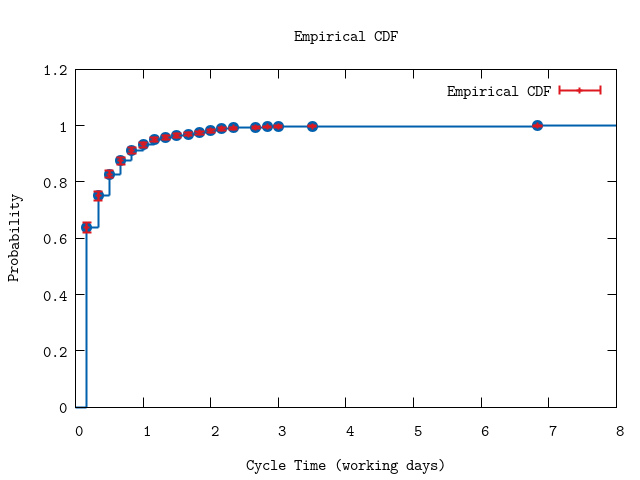

In [10]:
P.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Cycle Time (working days)",
    ylabel: "Probability",
    xrange: '[0:8]')
:"this is an inline image"

## Simple forecast using the empirical data

Using the histogram data for the throughput we perform a Monte Carlo simulation to get an estimation for the number of iterations needed to deplete the backlog. Since for a large enough number of samples results of a Monte Carlo simulation approximate the normal distribution. This provides a range for the uncertainty of the number of iterations. We express this as a probability using percentages.

In [11]:
{avg,sd,all} = U.mc(iterations, U.forecast_items(ctlist, size), collect_all?: true)
U.display {avg,sd,:+}
:"do not show this result in output"

50%    => 280.0 units
84%    => 295.0 units
97.5%  => 309.0 units
99.85% => 324.0 units


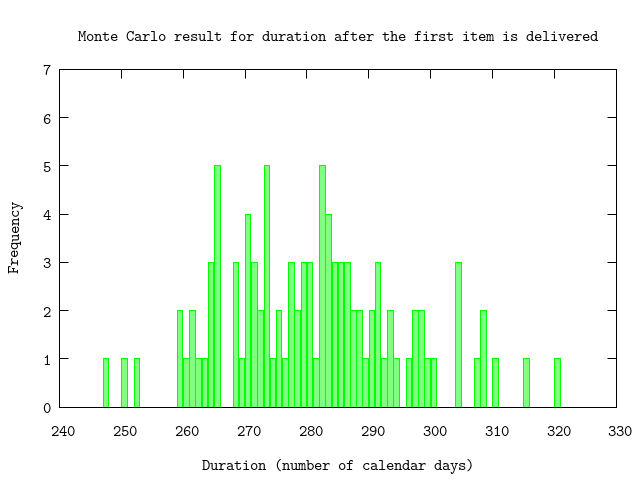

In [13]:
P.histogram(all,
    plottitle: "Monte Carlo result for duration after the first item is delivered",
    xlabel: "Duration (number of calendar days)",
    ylabel: "Frequency",
    yrange: '[0:7]')
:"this is an inline image"

## Forecasting using an Erlang distribution

Instead of directly using the raw data captured one can also use a known probability distribution. The parameter of the distribution is matched to the data. After matching the parameter value one uses the known distribution to forecast.

Here, we will use the _Erlang distribution_ [1]. This basically assumes that the data points are independent of each other. If the distribution of the _Delivery Rate_ is Poisson (see [Forecasting using delivery rate](Forecasting-fit-to-known-distribution.ipynb)) we expect that _Cycle Times_ follow an Erlang distribution.

#### Fitting an Erlang distribution to the data

The data in `hdata` is based on _Cycle Times_ bewteen single deliveries. Therefore, we expect the Erlang-1 distribution, which basically is the exponential distribution.

In [14]:
model = D.model {"erlang", 1.0}
options = [model: :linear]

result = {_,cov,parameters,_} = F.chi2fit hdata, {[2.5], model[:fun], &F.nopenalties/2}, 50, model: :linear
U.display(hdata,model,result,options)

Final:
    chi2:		1401.4882365558465
    Degrees of freedom:	18
    gradient:		[9.660588105311687e-7]
    parameters:		[2.6456227455943644]
    errors:		[0.012418260425177135]
    ranges:
			chi2:		1401.4882365558465	-	1401.560926799379
			parameter:	2.642269187094888	-	2.6456227460279225


:ok

The result returned by `chi2fit` indicates that given the Erlang-1 distribution we're at the most optimal fit (very small gradient) but that it describes the data very badly (Chi-squared statistic of over 180 per degree of freedom). For good fits we expect a Chi-squared statistic around 1 per degree of freedom.

#### Second try: time between batches of 10 deliveries

In the first try we have considered single completed items. With the amount of data we have available this may be too fine grained. Some times it helps by smoothing the data and considering larger chunks of deliveries. In this case, let's see what the data looks like in chunks of 10 deliveries.

Therefore, we will alter the data to determine the _Cycle Times_ between 10 completed items. We still expect an Erlang distribution and to be more specific, an Erlang-10 distribution since we will be considering batches of 10 deliveries.

In [15]:
batch = 10
binsize = 2/hours_in_day

bdel = deliveries
|> Stream.chunk_every(batch, batch, :discard)
|> Stream.map(& hd &1)

hdata = bdel
|> U.binerror(fun, bin: binsize, iterations: 1, correct: correct, workhours: workhours, cutoff: cutoff)

IO.puts "#{length(ctlist)} Cycle Times reduced to #{length(hdata)} bins"
:"do not show this result in output"

878 Cycle Times reduced to 28 bins


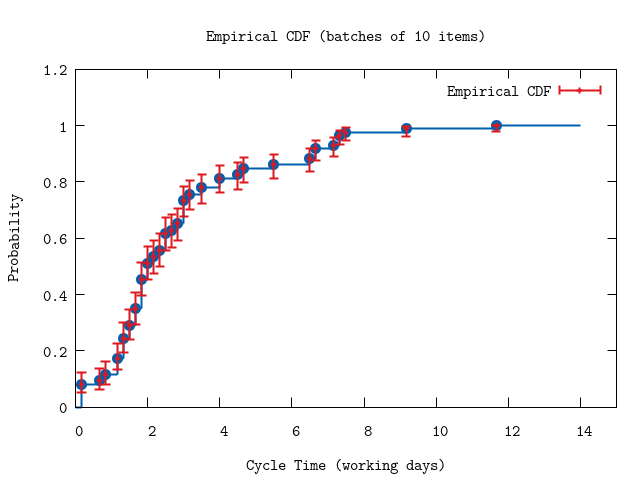

In [16]:
P.ecdf(hdata,
    plottitle: "Empirical CDF (batches of 10 items)",
    xlabel: "Cycle Time (working days)",
    ylabel: "Probability",
    xrange: '[0:15]')
:"this is an inline image"

The fit below shows that an Erlang-10 distribution does not describe the batched data.

In [17]:
model = D.model {"erlang", batch*1.0}

result = {_,cov,parameters,_} = F.chi2fit hdata, {[2.5], model[:fun], &F.nopenalties/2}, 50, model: :linear
U.display(hdata,model,result,options)
:"do not show this result in output"

Final:
    chi2:		3748757.980852812
    Degrees of freedom:	27
    gradient:		[-0.17209093639054504]
    parameters:		[3.5303335362979893]
    errors:		[1.6454050684689054e-4]
    ranges:
			chi2:		3748757.980852812	-	3748757.9808533373
			parameter:	3.530333523724308	-	3.530333543331993


#### Third try: considering only recent data

Perhaps not all data is relevant. As a variation we will consider only data after January 1st, 2019.

Again, batches of 10 deliveries.

In [18]:
recent = deliveries
|> Stream.filter(fn t -> Timex.after?(t, ~D[2019-01-01]) end)
|> Stream.chunk_every(batch, batch, :discard)
|> Stream.map(& hd &1)

hdata = recent
|> U.binerror(fun, bin: binsize, iterations: 1, correct: correct, workhours: workhours, cutoff: cutoff)

IO.puts "#{length(ctlist)} Cycle Times reduced to #{length(hdata)} bins"
:"do not show this result in output"

878 Cycle Times reduced to 14 bins


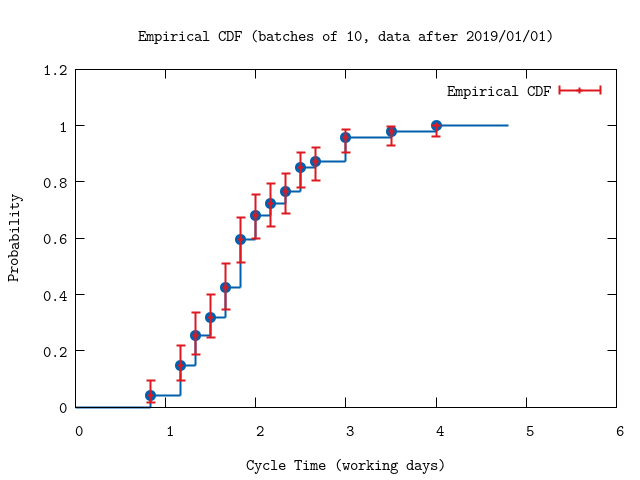

In [19]:
P.ecdf(hdata,
    plottitle: "Empirical CDF (batches of 10, data after 2019/01/01)",
    xlabel: "Cycle Time (working days)",
    ylabel: "Probability",
    xrange: '[0:6]')
:"this is an inline image"

The plot is very different from the one inthe previous section! The error bars are also larger because we have removed data.

In [20]:
result = {_,cov,[lambda],_} = F.chi2fit hdata, {[2.5], model[:fun], &F.nopenalties/2}, 50, model: :linear
U.display(hdata,model,result,options)
:"do not show this result in output"

Final:
    chi2:		3.2177459269210007
    Degrees of freedom:	13
    gradient:		[2.3145064276875778e-10]
    parameters:		[5.474676255213248]
    errors:		[0.1105774361037803]
    ranges:
			chi2:		3.2177459269210007	-	4.146884248390765
			parameter:	5.368366062762177	-	5.559455152955396


Indeed the fit seems to be a very good despite the low number of data points; a Chi-squared value of 0.8 per degree of freedom is good. The parameter (= delivery rate) is $$\lambda = 5.4 \pm 0.1 \,\,\textrm{items per work day}$$.

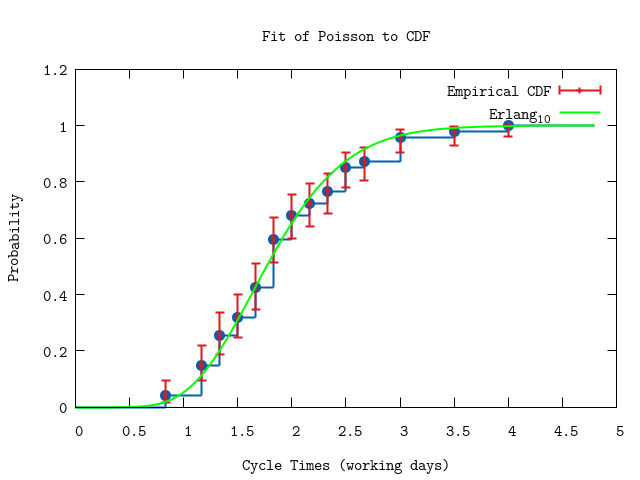

In [21]:
P.ecdf(hdata,
    plottitle: "Fit of Poisson to CDF",
    xlabel: "Cycle Times (working days)",
    ylabel: "Probability",
    title: "Erlang_{10}",
    func: D.erlangCDF(batch*1.0,lambda))
:"this is an inline image"

## Finding an appropriate subsequence

Instead of manually removing old data from our data set, `Chi2fit` provides a function for partitioning the data set into longest subsequences that will fit the chosen model.

In [22]:
batch = 10
binsize = 2/hours_in_day

options = [probes: probes, bin: binsize, init: List.duplicate({0.1,50.0},model[:df]), fitmodel: model, model: :linear]

# Find points in the delivery dates that indicate a change in the model.
# `find_all` is a lazy function, meaning it does not always traverse the entire data set.
# In the example below, it stops after finding 5 jumping points.
trends = bdel
|> fun.()
|> F.find_all(options)
|> Enum.take(5)
:"do not show this result in output"

In [23]:
trends
|> Enum.map(fn {chi,[rate],list} -> {chi, rate, Enum.sum(list), length(list)} end)
|> U.as_table({"Goodness of fit", "Delivery rate (items per working day)", "Duration (work days)", "Count of items"})
:"do not show this result in output"

Goodness of fit      |Delivery rate (items per working day)|Duration (work days)|Count of items
---------------------|-------------------------------------|--------------------|--------------
8.594041230934275    |5.303886896160837                    |93.27500000000146   |48            
14.76545944659221    |2.0047174100246057                   |76.77500000000146   |14            
2.8345609975017316   |49.99809889595503                    |2.5916666666671517  |4             
2.7331957165626005e-9|14.502794215234198                   |2.3958333333284827  |2             
5.617727177877458    |49.999373598531555                   |4.802777777782467   |5             


In [24]:
# Get the most recent sequence:
{_chi,[lambda],list} = hd trends
delivery_rate = lambda * 10 # items per 2 weeks
startdate = Timex.shift(~D[2019-05-13], days: -round(Enum.sum(list)/5*7)) # work days to calendar days

IO.puts ~s[The found sequence runs from #{Timex.format! startdate, "{Mshort} {D}, {YYYY}"} till #{Timex.format! ~D[2019-05-13], "{Mshort} {D}, {YYYY}"}]
IO.puts "Delivery rate = #{Float.round(delivery_rate,2)} items per 2 weeks"
:"do not show this result in output"

The found sequence runs from Jan 2, 2019 till May 13, 2019
Delivery rate = 53.04 items per 2 weeks


#### Forecasting

In [25]:
# The Erlang_1 distribution is equivalent to the Exponential distribution.
# We could have also used Erlang_10 and divided size by 10. This gives equivalent results.
{avg,sd} = U.mc(iterations, U.forecast_items(D.exponential(lambda), size))

IO.puts "Forecast using the parameter as fit with the Erlang_10 distribution:"
U.display {avg,sd,:+}
:"do not show this result in output"

Forecast using the parameter as fit with the Erlang_10 distribution:
50%    => 189.0 units
84%    => 195.0 units
97.5%  => 201.0 units
99.85% => 207.0 units


Or using the empirical data of the subsequence instead of the whole data set:

In [26]:
# Remember to divide size by 10 since `list` corresponds to cycle times of batches of 10
{avg,sd} = U.mc(iterations, U.forecast_items(list, size/10))

IO.puts "Forecast directly using the subsequence of the data set:"
U.display {avg,sd,:+}
:"do not show this result in output"

Forecast directly using the subsequence of the data set:
50%    => 196.0 units
84%    => 205.0 units
97.5%  => 214.0 units
99.85% => 223.0 units


## References

[1] _Erlang distribution_, https://en.wikipedia.org/wiki/Erlang_distribution

[2]: _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit

[3]: _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf

[4]: _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf